In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
import datetime


# Premise

We approach EDA from a perspective of an investor, whose interests are maximizing risk-adjusted returns. Here we will look at interest rate vs default rate, and then calculate a net adjusted annual return separated by the loan grade.

Next, we answer the question, are 36 month loans 


Lastly, we will build a model that can create a basket of investments that can outperform the market basket. These are the steps done and assumptions made.

    1. We first calculate the sharpe ratio using net adjusted return on all historical basket of loans. 
    2. We will build a regression model, using features chosen carefully through nested model testing, that will forecast the returns of all the loans in a validation dataset
    3. We will then use linear programming to set constraint and build a portfolio that maximizes the sharpe ratio with 10% of market liquidity
    4. We will then compare our model vs actual result to get a sense of whether we were able to outperform or not 

Additional analysis that can be done is accounting for changes in the risk free rate, and rebalancing of the portfolio year over year.

# Assumptions & Discussions

1. Funded Amount vs Funded Amount Inv: Where there are differences, lending tree stepped in to make up for the differences between loan amount and funed amount invested by investors. We will go ahead and use funded amount as a basis for all our analysis.
2. We assume all cash is deployed on year of x(has the most data) to reduce cash drag. We calculate IRR-> assuming we can reinvest at this rate 

# Data Cleansing

In [ ]:
https://www.lendingclub.com/public/images/0180344/content/aboutNAR/NAR.png

In [129]:
Image(url= "https://www.lendingclub.com/public/images/0180344/content/aboutNAR/NAR.png")

As an investor, you want to get a good grasp of two things of any investments, risk and reward. This analyis will mainly focus on that. 

Dissecting the data to too many categorical values can 

First we calculat the default percentage, we will include the "does not meet..." rows as valid loans, and throw out rest of the data that we don't have complete information on.

###data call outs
You can't trade on information that is not there yet.... 


In [298]:
###data load
df = pd.read_csv('./data/loan.csv', low_memory=False)

In [299]:
###cleaning data 
df['last_pymnt_d']=pd.to_datetime(df.last_pymnt_d)
df['issue_d']=pd.to_datetime(df.issue_d)

In [300]:
###fill missing last_payments(no payments) with issue date, may want a separete column for this treatme
###This is for calculation of IRRs later
df['last_pymnt_d'].fillna(df.issue_d,inplace=True)

In [301]:
###Some pre-processing for ease of calculations
df['issue_yr'] = df.issue_d.dt.year
df['issue_mo']= df.issue_d.dt.month
df['last_pymnt_yr'] = df.last_pymnt_d.dt.year
df['last_pymnt_mo']= df.last_pymnt_d.dt.month

In [302]:
###filter to loans we have complete data only
searchfor = ['Fully Paid', 'Charged Off', 'Default']
df_filtered = df[df['loan_status'].str.contains('|'.join(searchfor))].query("term == ' 36 months' and issue_yr <=2012")

In [303]:
###default flag 
df_filtered['loan_status_flag'] = np.where(df_filtered['loan_status'].str.contains('Fully Paid') ,1,0)

### Overall Default Percentage

In [304]:
1- df_filtered['loan_status_flag'].mean()

0.12997142017682095

### Overall Interest Rate

In [305]:
df_filtered['int_rate'].mean()

12.033947888569795

In [414]:
### IRR Calculations
###calculate differences in months for total duration of the loan 
df_filtered['mo_diff'] = pd.to_numeric((df_filtered['last_pymnt_yr'] - 
                          df_filtered['issue_yr'])*12 + df['last_pymnt_mo'] -df['issue_mo'])
df_filtered['avg_pymnt'] = (df_filtered['total_pymnt']+ df_filtered['total_rec_late_fee'])/(df_filtered['mo_diff']-1)

In [424]:
####Failed attempt at IRR
def irr_calc(x):  
    ##varible initialization
    initial_invest = -x['funded_amnt']
    avg_payment = x['avg_pymnt']
    num_payments = int(x['mo_diff'])-1    
    fully_paid = x['loan_status_flag']
    recovery = x['recoveries']
    chargeoff_fee = -x['collection_recovery_fee']
    ##IRR calculation, input: series of cash flows, total payment evenly divided and spread across the life of the loan 
    if(fully_paid==1):
        return (np.irr([initial_invest]+[avg_payment]*num_payments)+1)**12-1
    else:
        return ((np.irr([initial_invest]+[avg_payment]*num_payments + [recovery+chargeoff_fee])+1)**12-1)

In [460]:
balance = 4213
annual_interest_rate = 0.2
monthly_payment_rate =0.04
monthly_interest_rate = annual_interest_rate / 12
monthly_payment = monthly_payment_rate * balance
new_balance= (balance - monthly_payment) * (1 + monthly_interest_rate)

for month in range(1, 13):
    monthly_payment = monthly_payment_rate * balance
    balance = (balance - monthly_payment) * (1 + monthly_interest_rate)
    print('Month: %d \n Minimum monthly payment: %g \n Remaining balance: %g'\
          % (month, round(monthly_payment, 2), round(balance,2)))

Month: 1 
 Minimum monthly payment: 168.52 
 Remaining balance: 4111.89
Month: 2 
 Minimum monthly payment: 164.48 
 Remaining balance: 4013.2
Month: 3 
 Minimum monthly payment: 160.53 
 Remaining balance: 3916.89
Month: 4 
 Minimum monthly payment: 156.68 
 Remaining balance: 3822.88
Month: 5 
 Minimum monthly payment: 152.92 
 Remaining balance: 3731.13
Month: 6 
 Minimum monthly payment: 149.25 
 Remaining balance: 3641.58
Month: 7 
 Minimum monthly payment: 145.66 
 Remaining balance: 3554.19
Month: 8 
 Minimum monthly payment: 142.17 
 Remaining balance: 3468.89
Month: 9 
 Minimum monthly payment: 138.76 
 Remaining balance: 3385.63
Month: 10 
 Minimum monthly payment: 135.43 
 Remaining balance: 3304.38
Month: 11 
 Minimum monthly payment: 132.18 
 Remaining balance: 3225.07
Month: 12 
 Minimum monthly payment: 129 
 Remaining balance: 3147.67


In [425]:
df_filtered['irr']=df_filtered.apply(irr_calc, axis=1)

In [457]:
###Testing irr validation
test = [-9000]+[378.45]*36 +[444.3]
(np.irr(test)+1)**12-1

test2 = [-100,50,50,50]

In [459]:
(np.npv(.01, test)/9000)

0.30018256207803473

In [426]:
df_filtered[df_filtered['loan_status_flag']==0][['loan_amnt','last_pymnt_amnt','installment','issue_d','int_rate'
                                                 ,'last_pymnt_d', 'total_pymnt','mo_diff','avg_pymnt','irr'
                                                ,'collection_recovery_fee','recoveries','total_rec_late_fee']].head(5)

,loan_amnt,last_pymnt_amnt,installment,issue_d,int_rate,last_pymnt_d,total_pymnt,mo_diff,avg_pymnt,irr,collection_recovery_fee,recoveries,total_rec_late_fee
12,9000.0,305.38,305.38,2011-12-01,13.49,2012-07-01,2270.70,7.0,378.450000,-0.956653,4.1600,444.30,0.0
14,10000.0,325.74,325.74,2011-12-01,10.65,2013-10-01,7471.99,22.0,355.809048,-0.185724,6.3145,645.10,0.0
21,21000.0,701.73,701.73,2011-12-01,12.42,2013-09-01,14025.40,21.0,701.270000,-0.353582,0.0000,0.00,0.0
24,6000.0,198.46,198.46,2011-12-01,11.71,2012-10-01,2050.14,10.0,227.793333,-0.841043,2.5700,269.31,0.0
26,15000.0,0.00,514.64,2011-12-01,14.27,2011-12-01,0.00,0.0,-0.000000,NaN,0.0000,0.00,0.0


In [429]:
df_group = df_filtered.groupby(['grade','issue_yr'])['irr'].describe()
df_group

count      mean       std       min       25%       50%  \
grade issue_yr                                                              
A     2007         78.0  0.092898  0.078831 -0.475993  0.080878  0.086110   
      2008        312.0  0.073861  0.153649 -0.998162  0.085296  0.093198   
      2009       1198.0  0.070970  0.196064 -0.999563  0.089375  0.099805   
      2010       2547.0  0.068784  0.148511 -1.000000  0.073360  0.082434   
      2011       5541.0  0.103205  3.877280 -1.000000  0.069964  0.081847   
      2012      10642.0  0.055339  0.186651 -1.000000  0.078752  0.091287   
B     2007         97.0  0.026223  0.335409 -1.000000  0.094997  0.103687   
      2008        591.0  0.085989  1.248104 -1.000000  0.102150  0.114716   
      2009       1425.0  0.145457  2.787826 -1.000000  0.124247  0.132742   
      2010       2788.0  0.092405  0.821610 -1.000000  0.110024  0.123094   
      2011       4692.0  0.153028  4.605819 -1.000000  0.111622  0.126944   
      2012      16644.0  0.087032  0.430350 -1.000000  0.120705  0.143363   
C     2007        141.0 -0.010951  0.320404 -1.000000  0.107711  0.118051   
      2008        574.0  0.018797  0.523229 -1.000000  0.118865  0.129914   
      2009       1335.0  0.090043  0.534063 -1.000000  0.140276  0.151246   
      2010       2060.0  0.089742  0.373733 -1.000000  0.140419  0.153187   
      2011       2187.0  0.084665  0.373985 -1.000000  0.141830  0.158022   
      2012       9773.0  0.148224  5.189525 -1.000000  0.157148  0.178300   
D     2007         99.0 -0.004168  0.449190 -0.995495 -0.069689  0.139545   
      2008        416.0 -0.015747  0.485430 -1.000000  0.095711  0.145109   
      2009        812.0  0.073097  0.330026 -1.000000  0.154985  0.167818   
      2010       1247.0  0.132449  2.183424 -1.000000  0.158491  0.171068   
      2011       1254.0  0.094112  0.326486 -1.000000  0.164154  0.182844   
      2012       5016.0  0.110232  0.340417 -1.000000  0.192287  0.210702   
E     2007        100.0 -0.049868  0.392359 -0.999364 -0.197827  0.151344   
      2008        282.0  0.020862  0.443881 -1.000000  0.084801  0.163102   
      2009        304.0  0.059501  0.402866 -1.000000  0.171974  0.186316   
      2010        334.0  0.077327  0.359061 -1.000000  0.175857  0.192682   
      2011        271.0  0.093115  0.342874 -1.000000  0.178709  0.210880   
      2012        784.0  0.137148  0.360315 -1.000000  0.218758  0.244282   
F     2007         52.0 -0.189233  0.499277 -1.000000 -0.661544  0.163831   
      2008        110.0  0.045183  1.011434 -1.000000 -0.343183  0.177427   
      2009        104.0  0.052168  0.392042 -1.000000  0.171104  0.208662   
      2010         90.0  0.083653  0.556073 -1.000000  0.192195  0.210133   
      2011         54.0  0.101549  0.359627 -1.000000  0.199155  0.232893   
      2012        101.0  0.143230  0.421712 -0.999999  0.241951  0.267325   
G     2007         35.0 -0.042477  0.723119 -0.999264 -0.687037  0.188333   
      2008         86.0  0.005442  0.427784 -1.000000 -0.149430  0.201800   
      2009         53.0  0.080094  0.368365 -0.999962  0.024074  0.224543   
      2010         34.0  0.179391  0.986216 -1.000000 -0.095390  0.238064   
      2011         10.0 -0.030717  0.478558 -0.975847 -0.218579  0.224418   
      2012         24.0  0.203371  0.452406 -0.999820  0.278873  0.314731   

                     75%         max  
grade issue_yr                        
A     2007      0.125542    0.279666  
      2008      0.116220    0.272387  
      2009      0.122329    2.208682  
      2010      0.100526    2.987461  
      2011      0.099416  288.312870  
      2012      0.110121    1.581646  
B     2007      0.127788    1.294824  
      2008      0.137488   28.342205  
      2009      0.167055  104.324822  
      2010      0.149741   41.695246  
      2011      0.158012  312.748599  
      2012      0.176480   45.353837  
C     2007      0.128233    0.444468  
      2008      0.150754    9.595936  
     

In [411]:
####Confidence Intervals on IRR of overall market
df_conf_int = df_filtered.groupby(['issue_yr','grade'])['irr'].describe()
df_conf_int

count      mean       std       min       25%       50%  \
issue_yr grade                                                              
2007     A         78.0  0.089870  0.080475 -0.515843  0.080878  0.086110   
         B         97.0  0.010681  0.308527 -1.000000  0.094997  0.103687   
         C        141.0 -0.022448  0.327838 -1.000000  0.102903  0.117951   
         D         99.0 -0.043328  0.376643 -0.999315 -0.081948  0.139094   
         E        100.0 -0.057464  0.401297 -0.999364 -0.231530  0.150825   
         F         52.0 -0.205080  0.493508 -1.000000 -0.683090  0.163831   
         G         35.0 -0.095531  0.542864 -0.999264 -0.696737  0.187460   
2008     A        312.0  0.072141  0.157498 -0.999420  0.085296  0.092403   
         B        590.0  0.011967  0.308713 -1.000000  0.102052  0.113918   
         C        573.0 -0.002122  0.339169 -1.000000  0.116602  0.129521   
         D        415.0 -0.034939  0.389665 -1.000000  0.085971  0.145069   
         E        281.0  0.000544  0.377989 -1.000000  0.060087  0.162693   
         F        109.0 -0.052025  0.462593 -1.000000 -0.270925  0.177305   
         G         86.0 -0.011555  0.419524 -1.000000 -0.152111  0.201438   
2009     A       1198.0  0.066495  0.187438 -0.999927  0.088862  0.099769   
         B       1421.0  0.066125  0.270469 -1.000000  0.124168  0.132708   
         C       1327.0  0.067883  0.302813 -1.000000  0.140277  0.151097   
         D        807.0  0.069615  0.321102 -1.000000  0.154897  0.166123   
         E        301.0  0.053673  0.378984 -1.000000  0.171993  0.185709   
         F        104.0  0.035862  0.406483 -1.000000  0.165609  0.207995   
         G         53.0  0.059134  0.392181 -1.000000 -0.015243  0.223477   
2010     A       2547.0  0.065629  0.136267 -1.000000  0.073357  0.082211   
         B       2781.0  0.076326  0.225009 -1.000000  0.110014  0.123085   
         C       2052.0  0.082728  0.276859 -1.000000  0.140390  0.153051   
         D       1240.0  0.068376  0.328599 -1.000000  0.158483  0.170744   
         E        331.0  0.076374  0.346397 -1.000000  0.176179  0.192700   
         F         90.0  0.032764  0.428950 -1.000000  0.064977  0.209068   
         G         33.0  0.051033  0.521918 -0.999115 -0.186498  0.236869   
2011     A       5534.0  0.048637  0.179682 -1.000000  0.069965  0.081843   
         B       4690.0  0.074097  0.234123 -1.000000  0.111580  0.126903   
         C       2177.0  0.073401  0.299546 -1.000000  0.141846  0.157898   
         D       1250.0  0.085909  0.321957 -1.000000  0.164080  0.182716   
         E        269.0  0.090194  0.344980 -1.000000  0.180581  0.210880   
         F         54.0  0.088588  0.374111 -1.000000  0.199155  0.232893   
         G         10.0 -0.040500  0.485511 -0.993102 -0.259929  0.223436   
2012     A      10627.0  0.053321  0.189949 -1.000000  0.078761  0.091216   
         B      16616.0  0.078685  0.256601 -1.000000  0.120705  0.143359   
         C       9750.0  0.085893  0.316663 -1.000000  0.157123  0.177475   
         D       5004.0  0.099862  0.354799 -1.000000  0.192289  0.210699   
         E        782.0  0.121008  0.380352 -1.000000  0.218642  0.244159   
         F        100.0  0.141269  0.427311 -1.000000  0.247248  0.267350   
         G         24.0  0.199977  0.456912 -0.999998  0.278873  0.314731   

                     75%       max  
issue_yr grade                      
2007     A      0.125100  0.173158  
         B      0.127788  0.317265  
         C      0.125394  0.241789  
         D      0.153933  0.342723  
         E      0.159864  0.311236  
         F      0.179718  0.316515  
         G      0.210372  1.473069  
2008     A      0.115996  0.208588  
         B      0.135359  1.082407  
         C      0.146613  0.276075  
         D      0.158955  0.364165  
         E      0.185887  0.499596  
         F      0.201942  0.799593  
         G      0.215036  0.376854  
2009     A      0.121997  0.231552  


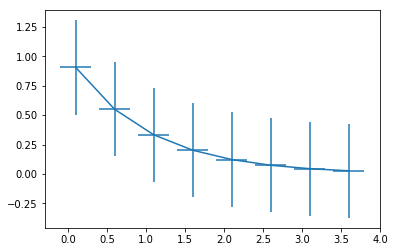

In [401]:
####Confidence Intervals on IRR of overall market
df_conf_int = df_filtered.groupby(['issue_yr'])['irr'].describe()
# example data
x = df_conf_int.index
y = df_conf_int.mean
yerr = df_conf_int.std

fig, ax = plt.subplots()
ax.errorbar(x, y, xerr=0.2, yerr=0.4)
plt.show()






